# Song Generation: Neural Style Transfer for audio

With the use of convolutional neural networks (CNNs), we saw a vast rise in works involving style transfer to create a new image involving the content from one image and the style from a different image. In this project, we will be investigating applications and usage of CNNs in generating audios from random noise containing the content (i.e. tempo, melody) of one audio clip and the style of another audio (i.e. instrument types, pitch). The solution to this problem can potentially allow generation of new audio through the mixture of two completely different types of audio content.

## Import libraries

In [1]:
import sys
import numpy as np
import tensorflow as tf
import librosa
from pydub import AudioSegment
import os
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sys import stderr
%matplotlib inline

/Users/williampark73/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Hyperparameters

In [2]:
CONTENT_FILENAME = "inputs/bensound-ukulele"
STYLE_FILENAME = "inputs/fire"
OUTPUT_FILENAME = "out_ukelele_fire"
extension = ".mp3" #".wav" #in case browser does not play .wav e.g. mozilla firefox
FFT_WINDOW_SIZE = 2048 #default n_fft in librosa 
HOP_LENGTH = int(FFT_WINDOW_SIZE/4) #default -- change this to regulate output length for fixed n_fft
N_CHANNELS = int(FFT_WINDOW_SIZE/2)+1#non-tunable
N_SAMPLES = 400 #clip length of y axis of spectograms in case they are longer
N_FILTERS = 4096 #number of filters for first and only CONV layer
FILTER_WIDTH = 11
TESTRESULTS = []
#optimization
ALPHA= 0.006 #loss = alpha*content + beta*style
BETA = 1
#learning_rate= 1e-3
learning_rate_list = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
iterations = 50 #max iterations per epoch
EPOCHS = 3

## Functions

In [3]:
def load_audio(path):
    display(Audio(path + extension))

In [4]:
def write_audio(result ,example ,output_path):
    a = np.zeros(example.shape)
    a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

    # This code is supposed to do phase reconstruction
    p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
    #for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S, hop_length = HOP_LENGTH)

    librosa.output.write_wav(output_path + ".wav" , x, fs)
    if extension == ".mp3":
        AudioSegment.from_wav(output_path + ".wav").export(output_path + extension, format=extension[1:])
        os.remove(output_path + ".wav")

In [5]:
# Reads wav file and produces spectrum
def convert_audio_to_spectogram(filename):
    x, fs = librosa.load(filename + extension) #fs is the sampling rate of the filename audio
    S = librosa.stft(x, n_fft=FFT_WINDOW_SIZE, hop_length=HOP_LENGTH)
    S = np.log1p(np.abs(S[:,:]))  #extracts the maginitude of frequency (rows) i at frame (column) j
    return S,fs

In [6]:
# Change Style shape to match Content Shape
# Change both shapes to have columns = min(CLIP_SIZE, N_SAMPLES) and rows = N_SAMPLES
def match_shapes(a_content, a_style, clip):
    CONTENT_SAMPLES = a_content.shape[1]
    CONTENT_CHANNELS = a_content.shape[0]
    STYLE_SAMPLES = a_style.shape[1]
    STYLE_CHANNELS = a_style.shape[0]
    
    if CONTENT_SAMPLES >= STYLE_SAMPLES :
        a_style = a_style[:CONTENT_CHANNELS, :CONTENT_SAMPLES]
    else:
        a_content = a_content[:STYLE_CHANNELS, :STYLE_SAMPLES]
    N_SAMPLES = a_content.shape[1]
    N_CHANNELS = a_content.shape[0]
    if clip < N_SAMPLES:
        a_style = a_style[:N_CHANNELS, :clip]
        a_content = a_content[:N_CHANNELS, :clip]
    return a_style, a_content

In [7]:
def plot_spectogram(images_list):
    Y_AXIS_TRIM = 400
    X_AXIS_TRIM = 400
    IMG_WIDTH = 10
    IMG_HEIGHT = 10
    plt.figure(figsize=(IMG_WIDTH, IMG_HEIGHT))
    for i in range(len(images_list)):
        plt.subplot(1, len(images_list), i+1)
        plt.title(images_list[i]["name"])
        plt.imshow(images_list[i]["data"][:Y_AXIS_TRIM,:X_AXIS_TRIM])
    plt.show()

In [8]:
step=0;
def step_handler_callback(interim_result, step, output_path = 'outputs/out'+str(step)):
    write_audio(interim_result , a_content,output_path)
    a_result, fs2 = convert_audio_to_spectogram(output_path) 
    load_audio(output_path)
    plot_spectogram([{"name":"Content","data": a_content},{"name":"Style","data": a_style},{"name":"Result","data": interim_result[0,0,:,:]}])

### Load style and content

In [9]:
print("Content File::")
load_audio(CONTENT_FILENAME)

print("Style File::")
load_audio(STYLE_FILENAME)

Content File::


Style File::


### Convert Audio to Spectogram

before resizing:: (1025, 433) (1025, 6305)
after resizing:: (1025, 400) (1025, 400)


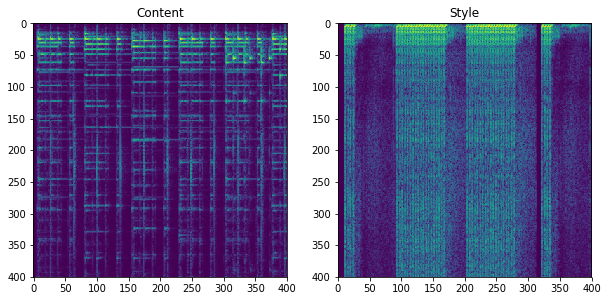

In [10]:
a_content,fs = convert_audio_to_spectogram(CONTENT_FILENAME)
a_style, fs = convert_audio_to_spectogram(STYLE_FILENAME) #rows=(nfft+1)/2, columns=(time_frames - nfft)/(hop_length)+ 5
print("before resizing::", a_style.shape , a_content.shape) 
a_style, a_content = match_shapes(a_content, a_style, N_SAMPLES)
print("after resizing::", a_style.shape , a_content.shape)
N_SAMPLES = a_style.shape[1]
plot_spectogram([{"name":"Content","data": a_content},{"name":"Style","data": a_style}])

## Neural Net 

##################################################
Test # 1
Learning Rate:  0.001
===
content shape (1, 1, 390, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5931.852051
  Number of iterations: 50
  Number of functions evaluations: 64
i: 0 Interim loss: 5931.852


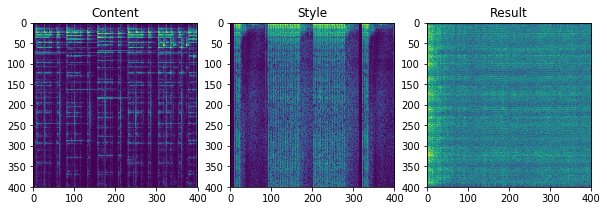

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4765.638184
  Number of iterations: 50
  Number of functions evaluations: 52
i: 1 Interim loss: 4765.638


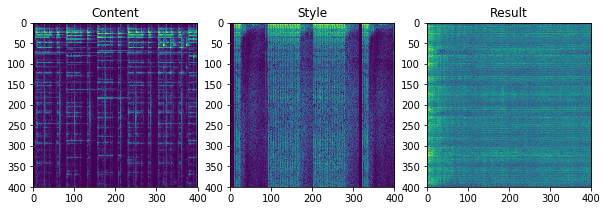

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4512.968262
  Number of iterations: 50
  Number of functions evaluations: 53
i: 2 Interim loss: 4512.9683


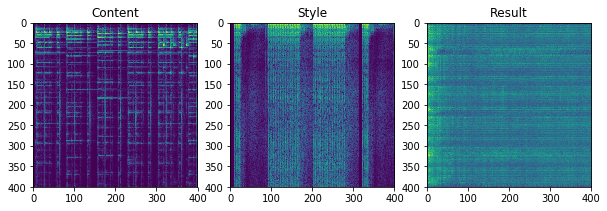

Final loss: 4512.9683
Final result: [[[[ 9.9120820e-01 -4.6256387e-01 -1.8244305e-01 ... -9.4555008e-01
    -5.1055927e-02 -6.5833056e-01]
   [ 3.6738026e-01  4.4405304e-02 -9.8980910e-01 ... -3.9035279e-01
    -5.2158409e-01  3.9728579e-01]
   [ 4.0150723e-01 -2.4770264e-01 -3.5658059e-01 ... -8.8554817e-01
     3.5159360e-04 -6.6608804e-01]
   ...
   [ 5.9074110e-01  1.3843344e+00  2.2054696e+00 ...  5.3942233e-01
    -3.3268952e-01 -7.4372035e-01]
   [ 5.6065243e-01  3.3736116e-01  9.3332839e-01 ...  4.6281767e-01
     5.6416702e-01  3.0913642e-01]
   [-5.0713742e-01 -5.8353256e-02  3.5818094e-01 ... -6.8872683e-03
     2.9651111e-01 -4.2313153e-01]]]]
##################################################
Test # 2
Learning Rate:  0.01
===
content shape (1, 1, 390, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5753.193359
  Number of iterations: 50
 

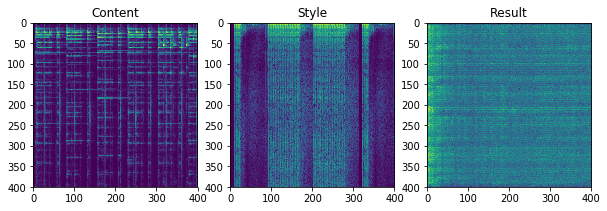

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4603.610352
  Number of iterations: 50
  Number of functions evaluations: 52
i: 1 Interim loss: 4603.6104


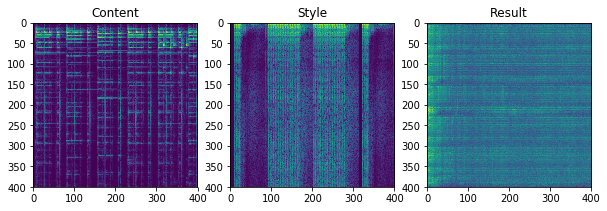

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4388.174805
  Number of iterations: 50
  Number of functions evaluations: 54
i: 2 Interim loss: 4388.175


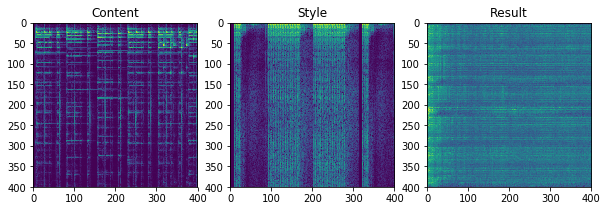

Final loss: 4388.175
Final result: [[[[-0.8781744  -0.7593573  -0.41037035 ... -0.28292736 -0.11055037
    -0.09798326]
   [-0.864157   -0.6824413  -1.2386202  ... -1.3852774  -1.1419421
     0.68444216]
   [ 0.76565236 -0.07508095 -1.001069   ... -1.4179046  -0.6554896
    -0.09173401]
   ...
   [ 0.68167907  0.3810083   1.9278842  ... -0.38779935  0.2929564
     0.54357916]
   [ 0.16553818  0.67410254  0.9312397  ...  0.6654988   0.17719874
     0.3262142 ]
   [-0.06917307  0.59518784  0.81814027 ...  0.69591194  0.681857
    -0.08588629]]]]
##################################################
Test # 3
Learning Rate:  0.1
===
content shape (1, 1, 390, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5885.543457
  Number of iterations: 50
  Number of functions evaluations: 62
i: 0 Interim loss: 5885.5435


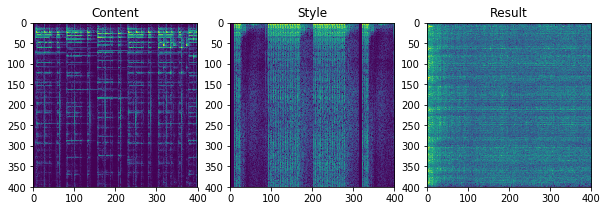

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4786.261719
  Number of iterations: 50
  Number of functions evaluations: 53
i: 1 Interim loss: 4786.2617


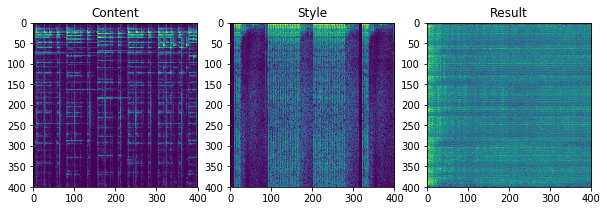

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4551.626465
  Number of iterations: 50
  Number of functions evaluations: 55
i: 2 Interim loss: 4551.6265


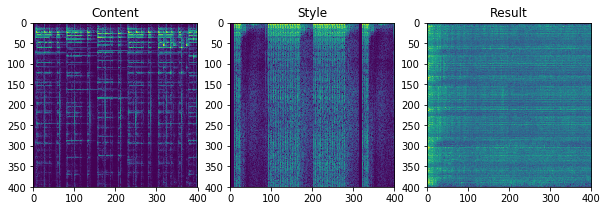

Final loss: 4551.6265
Final result: [[[[ 0.08035091  0.0511915  -0.5382795  ... -0.34719053 -0.09470357
    -0.5410337 ]
   [-0.02340717  0.3316246  -1.0760092  ... -0.25241452  0.03030589
     0.5495482 ]
   [ 0.42728773 -0.7961241  -0.8343044  ...  0.33902612  1.0744095
     1.2850742 ]
   ...
   [ 0.16820176  1.4588692   0.97956806 ...  0.7892264  -0.44920462
    -0.84775406]
   [ 0.2993447   2.0346727   1.1860527  ...  0.57974815  0.37013704
     0.4056672 ]
   [-0.23370232 -0.10677053  0.85030055 ...  0.739505    0.37549397
    -0.68645203]]]]
##################################################
Test # 4
Learning Rate:  1
===
content shape (1, 1, 390, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5760.330566
  Number of iterations: 50
  Number of functions evaluations: 63
i: 0 Interim loss: 5760.3306


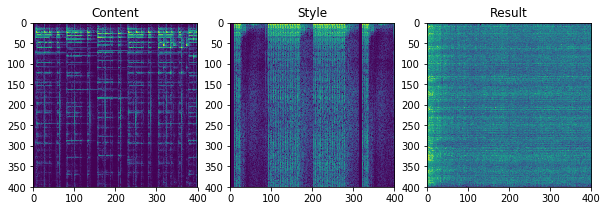

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4692.035645
  Number of iterations: 50
  Number of functions evaluations: 52
i: 1 Interim loss: 4692.0356


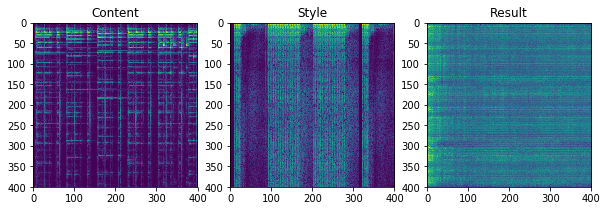

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4476.131348
  Number of iterations: 50
  Number of functions evaluations: 56
i: 2 Interim loss: 4476.1313


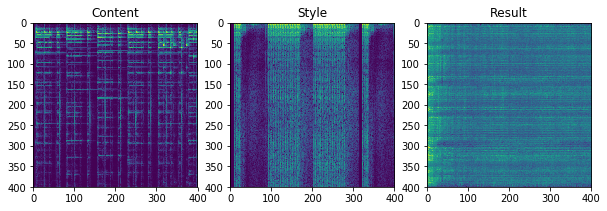

Final loss: 4476.1313
Final result: [[[[ 0.4817107   0.47719824 -0.07330421 ... -0.59634453 -0.50342774
    -0.28552485]
   [ 0.665356   -0.7774079  -0.4839256  ... -0.21033044 -0.56875086
     1.1513106 ]
   [-0.15569314  0.89835256 -0.14484587 ... -0.1586069   0.5413709
     0.1614152 ]
   ...
   [ 0.82166773  1.4288112   1.1277184  ...  0.02298404 -0.21063673
    -1.1046773 ]
   [-0.43357563 -0.13770257 -0.42700487 ... -0.18088166  0.05408369
    -1.3381228 ]
   [ 0.12933521 -0.09875786  0.3281444  ... -0.12938102  0.12043189
    -0.33939505]]]]
##################################################
Test # 5
Learning Rate:  10.0
===
content shape (1, 1, 390, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 6141.646973
  Number of iterations: 50
  Number of functions evaluations: 63
i: 0 Interim loss: 6141.647


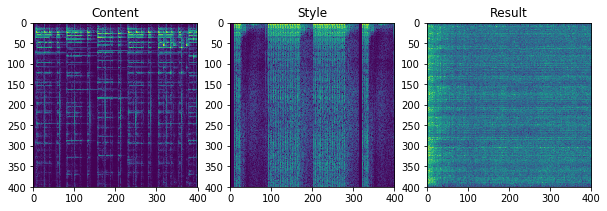

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4998.280273
  Number of iterations: 50
  Number of functions evaluations: 51
i: 1 Interim loss: 4998.2803


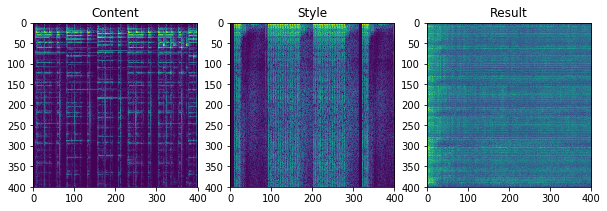

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4763.909668
  Number of iterations: 50
  Number of functions evaluations: 54
i: 2 Interim loss: 4763.9097


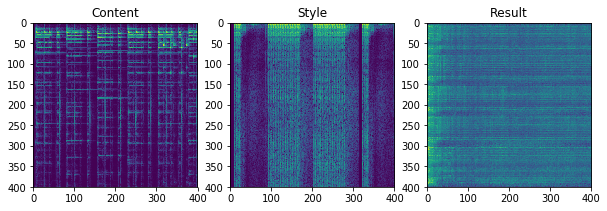

Final loss: 4763.9097
Final result: [[[[ 3.99991930e-01 -1.30526066e-01 -9.61340129e-01 ...  5.11435568e-01
     4.07990813e-01 -3.69433016e-01]
   [ 2.55970210e-01 -3.95054877e-01 -6.42378747e-01 ... -5.75565040e-01
    -9.20176879e-02 -4.86537814e-02]
   [ 1.23233974e+00  6.69263601e-01 -2.17551708e-01 ...  9.48040664e-01
     1.03251316e-01  4.33397472e-01]
   ...
   [ 8.04633021e-01  5.66362500e-01  1.80413544e+00 ... -8.04775059e-01
    -1.49585539e-02 -1.02572672e-01]
   [ 1.59599885e-01 -3.49097639e-01  6.57082021e-01 ... -6.99922144e-01
    -2.40707528e-02 -6.15875721e-02]
   [ 1.77985162e-01  1.18797727e-01  5.00255525e-01 ... -8.07474107e-02
     3.21424574e-01  1.69987732e-03]]]]
##################################################
Test # 6
Learning Rate:  100.0
===
content shape (1, 1, 390, 4096)
style shape (4096, 4096)
Started optimization:
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 602

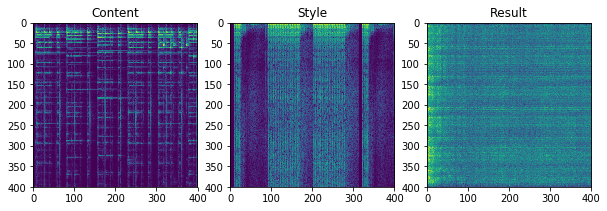

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4846.179688
  Number of iterations: 50
  Number of functions evaluations: 51
i: 1 Interim loss: 4846.1797


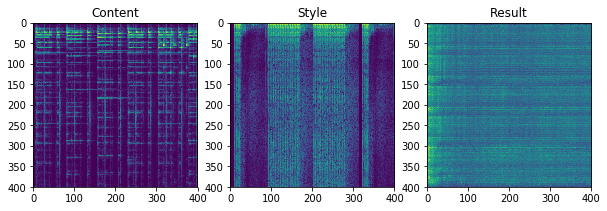

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 4601.552734
  Number of iterations: 50
  Number of functions evaluations: 53
i: 2 Interim loss: 4601.5527


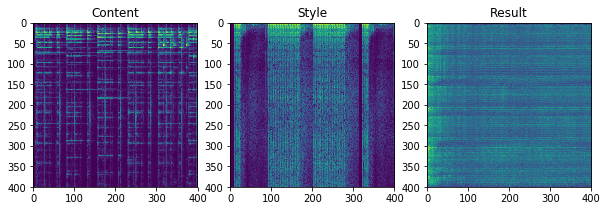

Final loss: 4601.5527
Final result: [[[[-0.03632531 -0.7580877   0.19039685 ...  0.27810058 -0.1491859
    -0.5277302 ]
   [-0.05099836 -0.6880776  -0.05386154 ... -0.68250424 -0.3755918
     0.04081964]
   [ 0.72619164 -0.8077138  -0.42229137 ... -0.87196314  0.8023353
     0.27788496]
   ...
   [ 0.8523683   0.4099101   1.2817085  ... -0.30210602  0.22124542
     0.2529774 ]
   [-0.4321566  -0.00309833  0.45210695 ... -0.23257263  0.6173541
     0.8400511 ]
   [ 0.14105877  0.1897874   0.65110916 ... -0.42745695  0.43794477
    -0.09392291]]]]


In [11]:
for i, learning_rate in enumerate(learning_rate_list):
    print("##################################################")
    print("Test #", i+1)
    print("Learning Rate: ", learning_rate)
    print("===")
    a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])#1x1x1025x400
    a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

    # filter shape is [filter_height, filter_width, in_channels, out_channels]
    std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * FILTER_WIDTH))
    filterr = np.random.randn(1, FILTER_WIDTH, N_CHANNELS, N_FILTERS)*std

    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:

        filter_tf = tf.constant(filterr, name="filter", dtype='float32')

        # data shape is "[batch, in_height, in_width, in_channels]",
        x_CS = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x_CS")
        conv_CS = tf.nn.conv2d(x_CS,filter_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv_CS")
        net_CS = tf.nn.relu(conv_CS)

        #extracting content
        content_features = net_CS.eval(feed_dict={x_CS: a_content_tf})
        print('content shape', content_features.shape)

        #extracting style
        style_features = net_CS.eval(feed_dict={x_CS: a_style_tf})
        features = np.reshape(style_features, (-1, N_FILTERS))
        style_gram = np.matmul(features.T, features) / N_SAMPLES
        print('style shape', style_gram.shape)

    with tf.Graph().as_default():
        filter_tf = tf.constant(filterr, name="filter", dtype='float32')

        # variable input
        x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")
        conv = tf.nn.conv2d(x,filter_tf,strides=[1, 1, 1, 1],padding="VALID",name="conv")
        net = tf.nn.relu(conv)

        #optimize
        result = None
        interim_result = None

        ##content loss
        content_loss = 2 * tf.nn.l2_loss(net - content_features)

        ##style loss
        _, height, width, number = map(lambda i: i.value, net.get_shape())
        size = height * width * number
        feats = tf.reshape(net, (-1, number))
        gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
        style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

        ## Overall loss
        loss = ALPHA*content_loss + BETA*style_loss

        ##Optimization   
        opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': iterations})    
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            print('Started optimization:')
            for i in range(EPOCHS):
                opt.minimize(sess)
                print('i:' , i , 'Interim loss:', loss.eval())
                interim_result = x.eval()
                step_handler_callback(interim_result, i)

        ## result
            print ('Final loss:', loss.eval())
            result = x.eval()
            print('Final result:', result)
            
            TESTRESULTS.append(loss.eval())

## Comparison Plot - Learning Rate

[4512.9683, 4388.175, 4551.6265, 4476.1313, 4763.9097, 4601.5527]


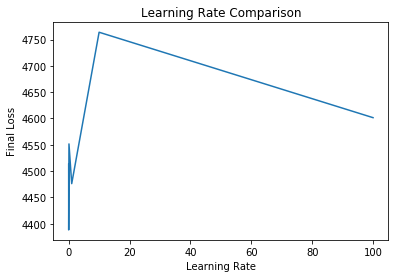

In [13]:
x = learning_rate_list
y = TESTRESULTS
print(y)

plt.plot(x, y)
plt.title("Learning Rate Comparison")
plt.xlabel("Learning Rate")
plt.ylabel("Final Loss")
plt.show()

## Invert spectrogram and save the result

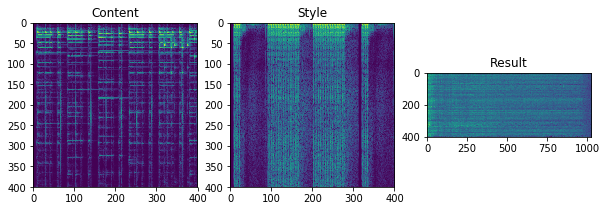

In [19]:
step_handler_callback(result, 47, output_path = OUTPUT_FILENAME)